## **`Persistence Diagram Example`**

In [ ]:
!pip install numpy matplotlib scipy
!pip install ripser

import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=595c926384c55f81fcd89fa8576227e4df6cb2c49aebac55d7805725b710e76b
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


Computing persistent homology...
Found 100 H0 features.
Found 7 H1 features.


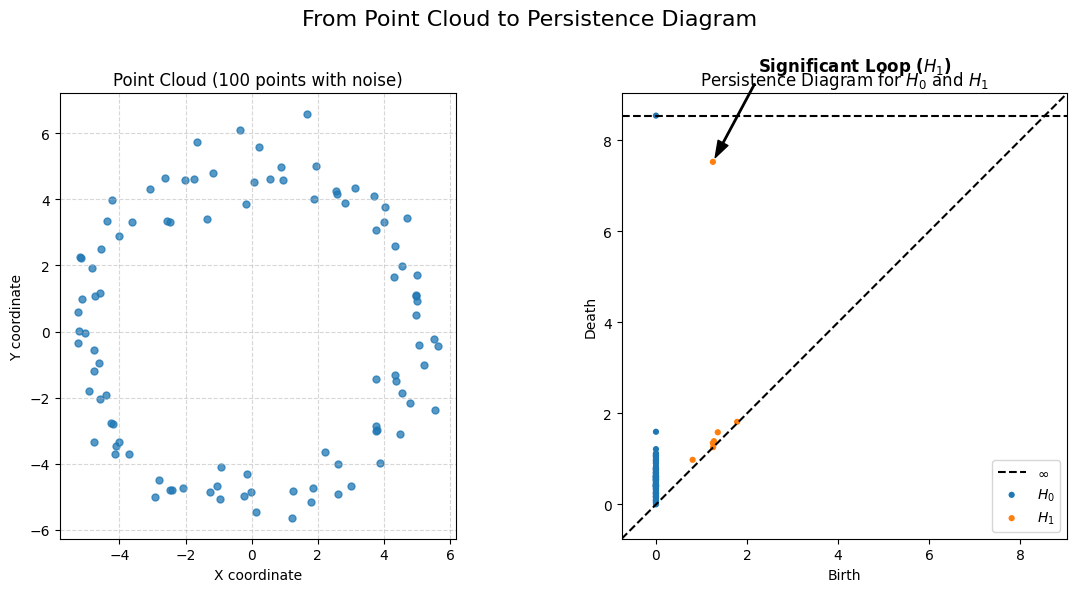

In [ ]:
# --- 1. Generate Data ---
# Create a point cloud shaped like a circle (an annulus) with some noise.
# This structure has one clear, significant H1 feature (the main loop).

N_points = 100  # Number of points
radius = 5.0    # Radius of the circle
noise_std = 0.5 # Amount of noise to add

# Generate points evenly spaced on a circle
angles = np.linspace(0, 2 * np.pi, N_points)
x = radius * np.cos(angles)
y = radius * np.sin(angles)

# Stack them into a (N_points, 2) array
data = np.vstack([x, y]).T

# Add Gaussian noise to each point
data += np.random.normal(scale=noise_std, size=data.shape)


# --- 2. Compute Persistent Homology ---
# Use ripser to compute the persistence diagrams for H0 and H1.
# ripser takes a point cloud and returns a dictionary with the diagrams.
# 'cocycles=True' can be useful for other analyses but is not needed here.
# 'maxdim=1' tells ripser to compute up to H1 (we don't need H2).

print("Computing persistent homology...")
persistence = ripser(data, maxdim=1)
diagrams = persistence['dgms']

# diagrams is a list: diagrams[0] is H0, diagrams[1] is H1, etc.
h0_diagram = diagrams[0]
h1_diagram = diagrams[1]

print(f"Found {len(h0_diagram)} H0 features.")
print(f"Found {len(h1_diagram)} H1 features.")


# --- 3. Visualize the Results ---
# Create a 2-panel plot: point cloud on the left, persistence diagram on the right.

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('From Point Cloud to Persistence Diagram', fontsize=16)

# Panel 1: The Point Cloud
ax = axes[0]
ax.scatter(data[:, 0], data[:, 1], s=25, alpha=0.75)
ax.set_title(f'Point Cloud ({N_points} points with noise)')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', alpha=0.5)

# Panel 2: The Persistence Diagram
ax = axes[1]
# Use the persim library's plotting function for a standard look
plot_diagrams(diagrams, ax=ax, show=False) # show=False to control when to display
ax.set_title('Persistence Diagram for $H_0$ and $H_1$')

# Annotate the most persistent H1 feature
# The most persistent feature is the one with the largest (death - birth) value.
# For H1, we ignore points with infinite death time (if any).
finite_h1 = h1_diagram[np.isfinite(h1_diagram[:, 1])]
if len(finite_h1) > 0:
    persistence_values = finite_h1[:, 1] - finite_h1[:, 0]
    most_persistent_idx = np.argmax(persistence_values)
    b, d = finite_h1[most_persistent_idx]

    # Add an annotation arrow
    ax.annotate('Significant Loop ($H_1$)',
                xy=(b, d),
                xytext=(b + 1, d + 2),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                fontsize=12,
                fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.savefig('persistence_example.png', dpi=300)
plt.show()

## **Rips filtration of simplicial complexes illustrating the birth and death of loops**

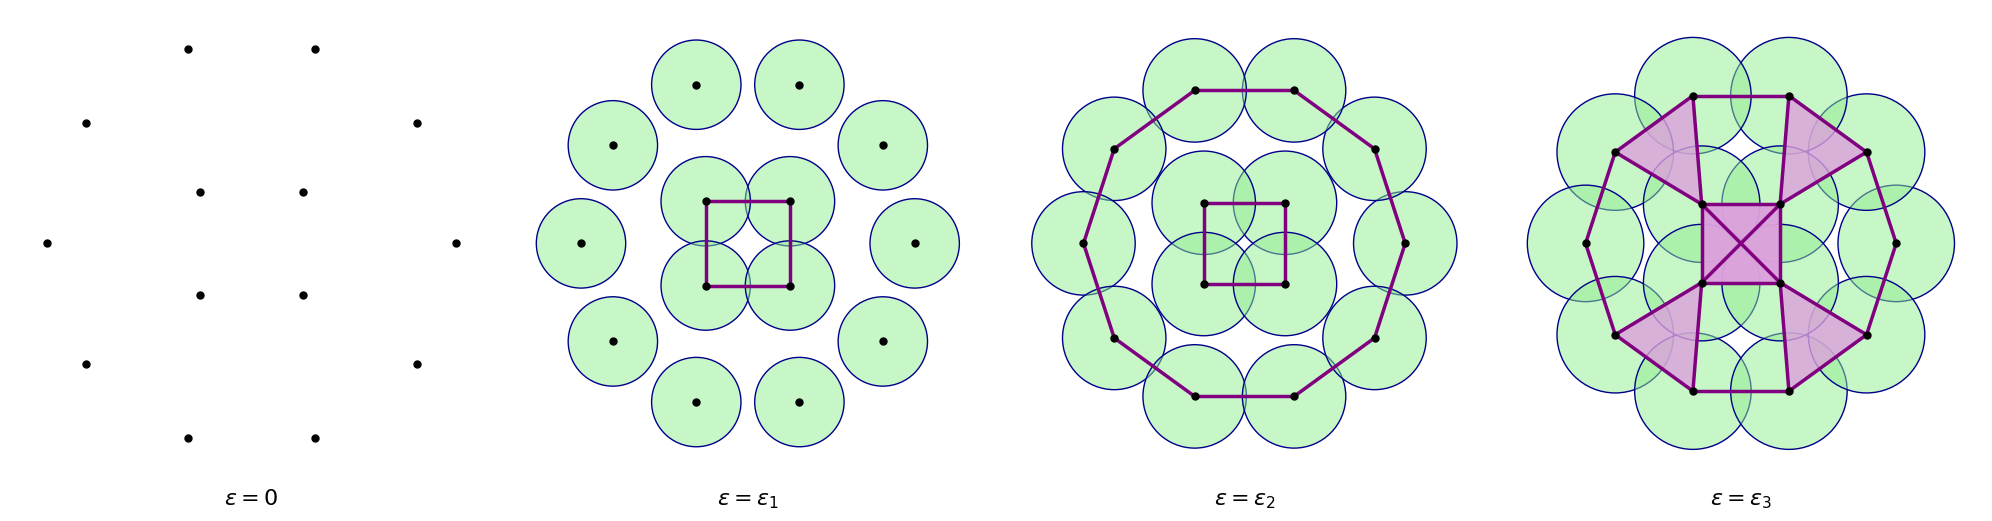

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon
from scipy.spatial.distance import pdist, squareform
import itertools

def generate_points(n_outer=10, n_inner=4, r_outer=2.8, r_inner=1.0):
    """
    Generates a set of points arranged in two concentric circles.

    The parameters are chosen carefully to ensure the desired sequence of
    topological events (inner loop birth, outer loop birth, inner loop death).
    """
    # Outer points forming a decagon
    outer_angles = np.linspace(0, 2 * np.pi, n_outer, endpoint=False)
    outer_points = r_outer * np.column_stack([np.cos(outer_angles), np.sin(outer_angles)])

    # Inner points forming a diamond (rotated square)
    inner_angles = np.linspace(0, 2 * np.pi, n_inner, endpoint=False) + np.pi / n_inner
    inner_points = r_inner * np.column_stack([np.cos(inner_angles), np.sin(inner_angles)])

    points = np.vstack([outer_points, inner_points])
    return points

def get_rips_complex(points, epsilon):
    """
    Computes the Vietoris-Rips complex for a given epsilon.
    Returns a dictionary of simplices up to dimension 2.
    """
    if epsilon == 0:
        return {0: [], 1: [], 2: []}

    dist_matrix = squareform(pdist(points))
    n = len(points)

    simplices = {0: [[i] for i in range(n)], 1: [], 2: []}

    # 1-simplices (edges)
    for i, j in itertools.combinations(range(n), 2):
        if dist_matrix[i, j] <= epsilon:
            simplices[1].append([i, j])

    # 2-simplices (triangles)
    for i, j, k in itertools.combinations(range(n), 3):
        if (dist_matrix[i, j] <= epsilon and
            dist_matrix[j, k] <= epsilon and
            dist_matrix[i, k] <= epsilon):
            simplices[2].append([i, j, k])

    return simplices

def plot_rips_panel(ax, points, epsilon, label):
    """
    Plots a single panel of the Rips filtration for a given epsilon.
    """
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xlabel(label, fontsize=16, labelpad=10)

    # Plot points
    ax.scatter(points[:, 0], points[:, 1], c='black', s=25, zorder=4)

    if epsilon > 0:
        simplices = get_rips_complex(points, epsilon)

        # Plot balls of radius epsilon/2
        for p in points:
            circle = Circle(p, epsilon / 2, facecolor='#90EE90', alpha=0.5, zorder=1) # Light green
            ax.add_patch(circle)
            edge_circle = Circle(p, epsilon / 2, facecolor='none', edgecolor='#00008B', linewidth=1.0, zorder=1) # Dark blue
            ax.add_patch(edge_circle)

        # Plot 2-simplices (triangles)
        for tri_indices in simplices[2]:
            triangle = Polygon(points[tri_indices], facecolor='#DDA0DD', alpha=0.8, zorder=2) # Plum
            ax.add_patch(triangle)

        # Plot 1-simplices (edges)
        for edge_indices in simplices[1]:
            p1, p2 = points[edge_indices]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='#800080', lw=2.5, zorder=3) # Purple

    # Set plot limits with a little padding
    padding = epsilon / 2 + 0.5
    ax.set_xlim(points[:, 0].min() - padding, points[:, 0].max() + padding)
    ax.set_ylim(points[:, 1].min() - padding, points[:, 1].max() + padding)


# --- Main script ---
if __name__ == '__main__':
    # 1. Generate the point cloud
    points = generate_points()

    # 2. Define the sequence of epsilon values for the filtration
    # These values are chosen based on the distances between points to show the desired features.
    # d_inner_adj ~ 1.41 | d_outer_adj ~ 1.73 | d_inner_diag = 2.0
    epsilons = [0, 1.5, 1.8, 2.1]
    labels = [r'$\epsilon=0$', r'$\epsilon=\epsilon_1$', r'$\epsilon=\epsilon_2$', r'$\epsilon=\epsilon_3$']

    # 3. Create the plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.patch.set_facecolor('white')

    for ax, eps, label in zip(axes, epsilons, labels):
        plot_rips_panel(ax, points, eps, label)

    plt.tight_layout(pad=1.0)
    plt.show()

## **Fundamental Theorem**

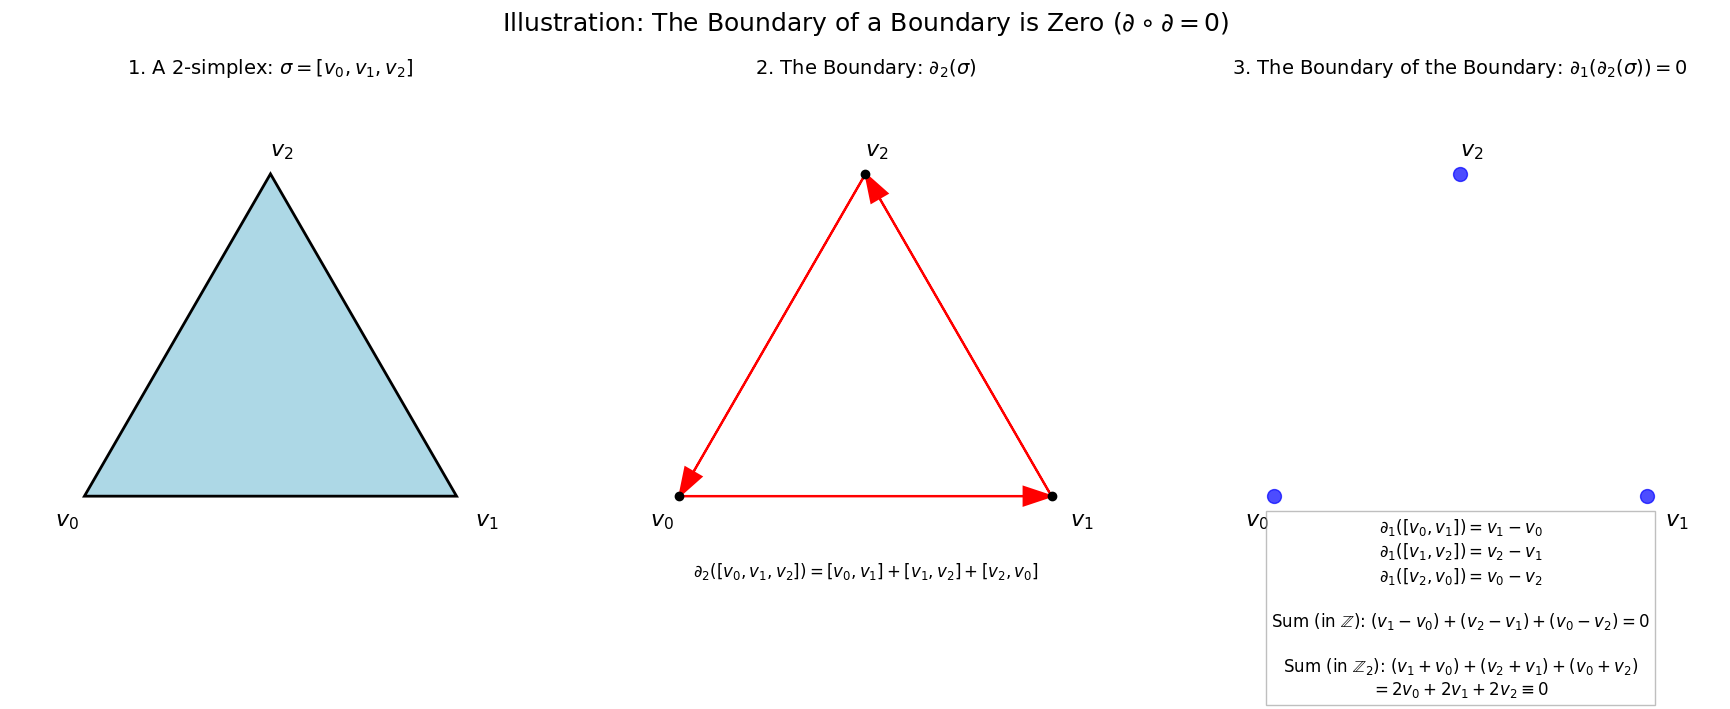

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Initial Settings ---

# Define the coordinates of the vertices of a triangle
v = np.array([
    [0, 0],      # v0
    [1, 0],      # v1
    [0.5, np.sqrt(3)/2]  # v2
])

# Create a figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6.5))
fig.suptitle("Illustration: The Boundary of a Boundary is Zero ($\partial \circ \partial = 0$)", fontsize=18, y=0.98)

# Remove axes for a cleaner look
for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.1)
    ax.axis('off')

# --- 2. Panel 1: The 2-Simplex (Triangle) ---
ax1 = axes[0]
ax1.set_title("1. A 2-simplex: $\sigma = [v_0, v_1, v_2]$", fontsize=14, pad=10)

# Draw the filled triangle (the "solid shape")
triangle = plt.Polygon(v, closed=True, fc='lightblue', ec='black', linewidth=2)
ax1.add_patch(triangle)

# Add labels for the vertices
labels = ['$v_0$', '$v_1$', '$v_2$']
offsets = [[-0.08, -0.08], [0.05, -0.08], [0, 0.05]]
for i, label in enumerate(labels):
    ax1.text(v[i, 0] + offsets[i][0], v[i, 1] + offsets[i][1], label, fontsize=16)

# --- 3. Panel 2: The Boundary of the Simplex (Oriented Edges) ---
ax2 = axes[1]
ax2.set_title("2. The Boundary: $\partial_2(\sigma)$", fontsize=14, pad=10)

# Draw the vertices as points
ax2.plot(v[:, 0], v[:, 1], 'ko', markersize=6)
for i, label in enumerate(labels):
    ax2.text(v[i, 0] + offsets[i][0], v[i, 1] + offsets[i][1], label, fontsize=16)

# Draw the edges as arrows to indicate orientation
# Standard orientation is [v0,v1], [v1,v2], [v2,v0]
edges = [(v[0], v[1]), (v[1], v[2]), (v[2], v[0])]
for start, end in edges:
    ax2.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_width=0.05, length_includes_head=True, fc='red', ec='red', linewidth=1.5)

# Add the boundary formula
ax2.text(0.5, -0.2,
         r'$\partial_2([v_0,v_1,v_2]) = [v_0,v_1] + [v_1,v_2] + [v_2,v_0]$',
         ha='center', va='center', fontsize=12)

# --- 4. Panel 3: The Boundary of the Boundary (Vertices Cancel Out) ---
ax3 = axes[2]
ax3.set_title("3. The Boundary of the Boundary: $\partial_1(\partial_2(\sigma))=0$", fontsize=14, pad=10)

# Draw only the vertices, which are the final result
ax3.plot(v[:, 0], v[:, 1], 'bo', markersize=10, alpha=0.7)
for i, label in enumerate(labels):
    ax3.text(v[i, 0] + offsets[i][0], v[i, 1] + offsets[i][1], label, fontsize=16)

# Show the calculation leading to zero
# Each vertex is a final point (+1) for one edge and an initial point (-1) for another
calculation_text = (
    r"$\partial_1([v_0,v_1]) = v_1 - v_0$" + "\n" +
    r"$\partial_1([v_1,v_2]) = v_2 - v_1$" + "\n" +
    r"$\partial_1([v_2,v_0]) = v_0 - v_2$" + "\n\n" +
    r"Sum (in $\mathbb{Z}$): $(v_1 - v_0) + (v_2 - v_1) + (v_0 - v_2) = 0$" + "\n\n" +
    r"Sum (in $\mathbb{Z}_2$): $(v_1+v_0) + (v_2+v_1) + (v_0+v_2)$" + "\n" +
    r"$= 2v_0 + 2v_1 + 2v_2 \equiv 0$"
)
ax3.text(0.5, -0.3, calculation_text, ha='center', va='center', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

# --- 5. Save and Display ---
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for main title
plt.savefig("homology_theorem_example.png", dpi=300)
plt.show()


## **Piecewise Functions Example**

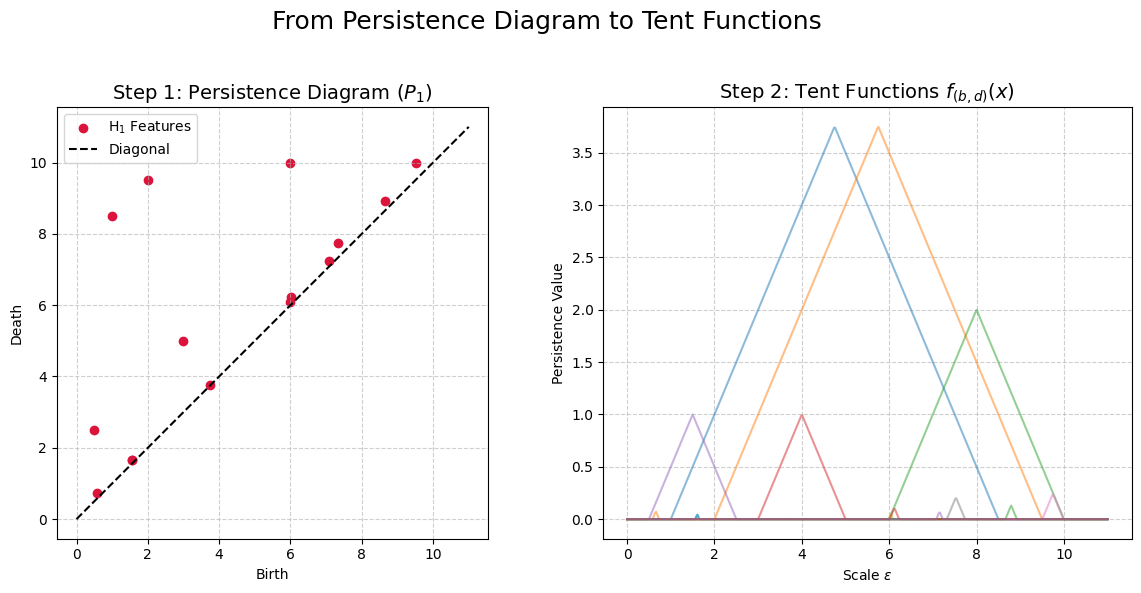

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Generate Persistence Diagram ---
np.random.seed(42)

# Signal features
diagram_signal = np.array([
    [1.0, 8.5],
    [2.0, 9.5],
    [6.0, 10.0],
    [3.0, 5.0],
    [0.5, 2.5]
])

# Noise features
n_noise = 10
birth_noise = np.random.uniform(0, 10, n_noise)
persistence_noise = np.random.uniform(0, 0.5, n_noise)
death_noise = birth_noise + persistence_noise
diagram_noise = np.vstack([birth_noise, death_noise]).T

# Full diagram
persistence_diagram = np.vstack([diagram_signal, diagram_noise])

# --- 2. Tent Function Definition ---
def tent_function_vec(b, d, x):
    m = (b + d) / 2
    return np.where(
        (x > b) & (x <= m), x - b,
        np.where((x > m) & (x < d), d - x, 0.0)
    )

# --- 3. Compute Tent Functions ---
x_vals = np.linspace(0, 11, 500)
all_tents = np.array([tent_function_vec(b, d, x_vals) for b, d in persistence_diagram])

# --- 4. Plot Persistence Diagram and Tent Functions ---
fig = plt.figure(figsize=(12, 6))
fig.suptitle('From Persistence Diagram to Tent Functions', fontsize=18, y=0.98)

# Plot 1: Persistence Diagram
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(persistence_diagram[:, 0], persistence_diagram[:, 1], c='crimson', label='H$_1$ Features')
ax1.plot([0, 11], [0, 11], 'k--', label='Diagonal')
ax1.set_title('Step 1: Persistence Diagram ($P_1$)', fontsize=14)
ax1.set_xlabel('Birth')
ax1.set_ylabel('Death')
ax1.set_aspect('equal')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Tent Functions
ax2 = plt.subplot(1, 2, 2)
for i in range(len(persistence_diagram)):
    ax2.plot(x_vals, all_tents[i, :], alpha=0.5)
ax2.set_title('Step 2: Tent Functions $f_{(b,d)}(x)$', fontsize=14)
ax2.set_xlabel('Scale $\epsilon$')
ax2.set_ylabel('Persistence Value')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('landscape_part1.png', dpi=300)
plt.show()


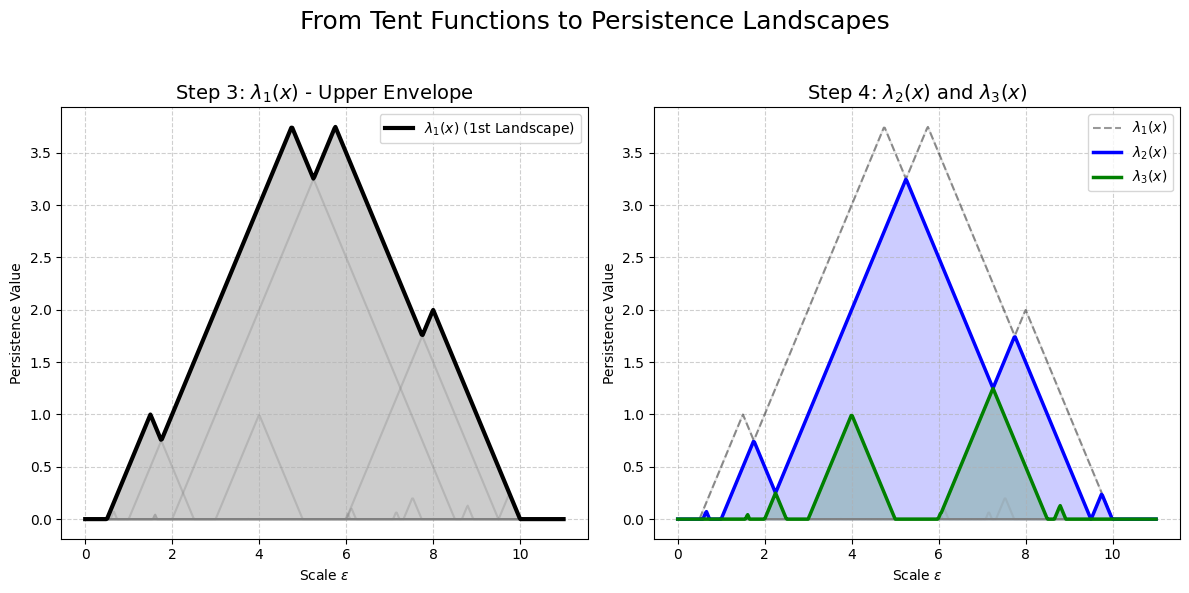

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# --- Load the same Persistence Diagram and Tent Functions ---
np.random.seed(42)

diagram_signal = np.array([
    [1.0, 8.5],
    [2.0, 9.5],
    [6.0, 10.0],
    [3.0, 5.0],
    [0.5, 2.5]
])

n_noise = 10
birth_noise = np.random.uniform(0, 10, n_noise)
persistence_noise = np.random.uniform(0, 0.5, n_noise)
death_noise = birth_noise + persistence_noise
diagram_noise = np.vstack([birth_noise, death_noise]).T

persistence_diagram = np.vstack([diagram_signal, diagram_noise])

def tent_function_vec(b, d, x):
    m = (b + d) / 2
    return np.where(
        (x > b) & (x <= m), x - b,
        np.where((x > m) & (x < d), d - x, 0.0)
    )

x_vals = np.linspace(0, 11, 500)
all_tents = np.array([tent_function_vec(b, d, x_vals) for b, d in persistence_diagram])

# --- Compute Landscape Functions ---
sorted_tents = -np.sort(-all_tents, axis=0)  # Descending sort
lambda_1 = sorted_tents[0, :]
lambda_2 = sorted_tents[1, :]
lambda_3 = sorted_tents[2, :]

# --- Plot Landscape Construction ---
fig = plt.figure(figsize=(12, 6))
fig.suptitle('From Tent Functions to Persistence Landscapes', fontsize=18, y=0.98)

# Plot 3: lambda_1
ax1 = plt.subplot(1, 2, 1)
for i in range(len(persistence_diagram)):
    ax1.plot(x_vals, all_tents[i, :], color='gray', alpha=0.3)
ax1.plot(x_vals, lambda_1, color='black', linewidth=3, label='$\lambda_1(x)$ (1st Landscape)')
ax1.fill_between(x_vals, lambda_1, color='black', alpha=0.2)
ax1.set_title('Step 3: $\lambda_1(x)$ - Upper Envelope', fontsize=14)
ax1.set_xlabel('Scale $\epsilon$')
ax1.set_ylabel('Persistence Value')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 4: lambda_2 and lambda_3
ax2 = plt.subplot(1, 2, 2)
for i in range(len(persistence_diagram)):
    ax2.plot(x_vals, all_tents[i, :], color='gray', alpha=0.2)
ax2.plot(x_vals, lambda_1, color='black', linestyle='--', alpha=0.4, label='$\lambda_1(x)$')
ax2.plot(x_vals, lambda_2, color='blue', linewidth=2.5, label='$\lambda_2(x)$')
ax2.plot(x_vals, lambda_3, color='green', linewidth=2.5, label='$\lambda_3(x)$')
ax2.fill_between(x_vals, lambda_2, color='blue', alpha=0.2)
ax2.fill_between(x_vals, lambda_3, color='green', alpha=0.2)
ax2.set_title('Step 4: $\lambda_2(x)$ and $\lambda_3(x)$', fontsize=14)
ax2.set_xlabel('Scale $\epsilon$')
ax2.set_ylabel('Persistence Value')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('landscape_part2.png', dpi=300)
plt.show()


## **Sliding Window**

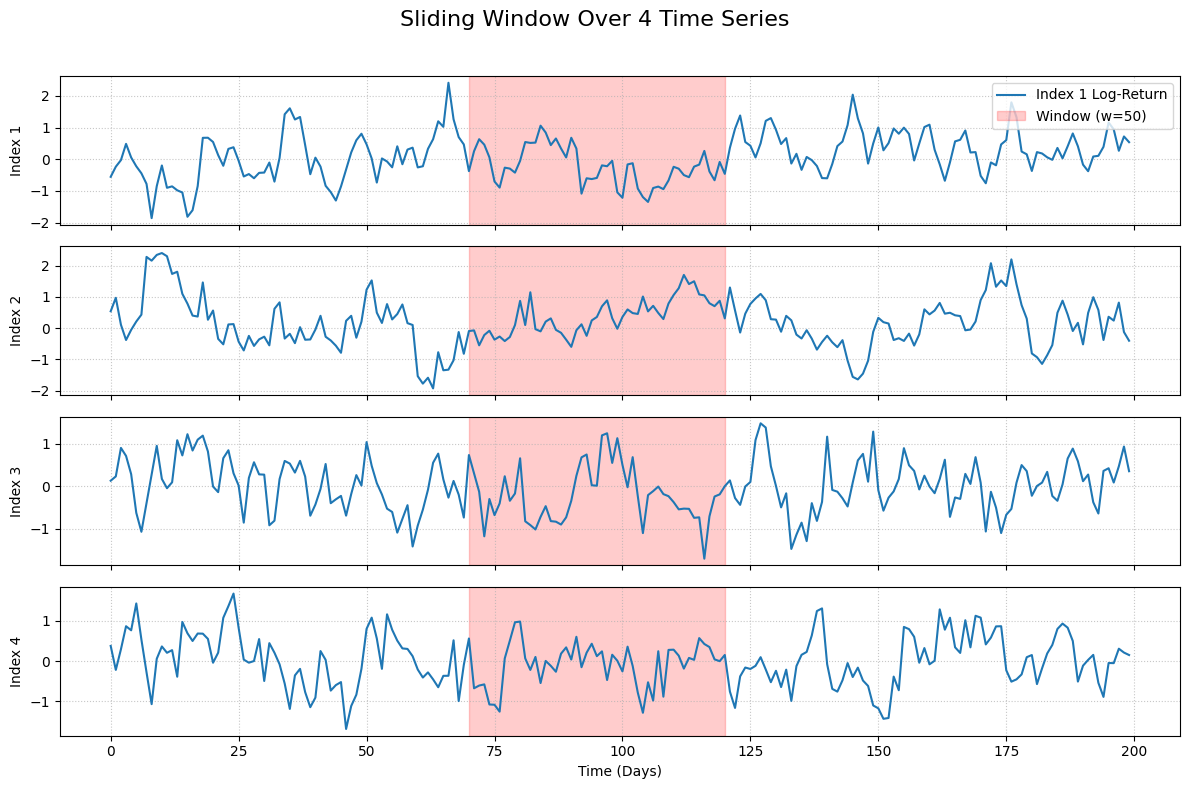

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
d = 4  # Number of time series
total_days = 200
w = 50  # Window length
window_start = 70

# --- 2. Generate Coherent Fake Financial Data ---
# Use a random seed so both scripts generate the same data
np.random.seed(42)
data = np.zeros((d, total_days))
for i in range(d):
    # Create a simple autoregressive model (AR1) to mimic financial returns
    phi = 0.6 + np.random.rand() * 0.3 # Different mean-reversion for each series
    noise = np.random.randn(total_days) * 0.5
    data[i, 0] = noise[0]
    for n in range(1, total_days):
        data[i, n] = phi * data[i, n-1] + noise[n]

# --- 3. Create the Visualization ---
fig, axes = plt.subplots(d, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Sliding Window Over 4 Time Series', fontsize=16)

for i in range(d):
    ax = axes[i]
    ax.plot(data[i, :], label=f'Index {i+1} Log-Return')

    # Highlight the sliding window using axvspan
    ax.axvspan(window_start, window_start + w, color='red', alpha=0.2, label=f'Window (w={w})')

    ax.set_ylabel(f'Index {i+1}')
    ax.grid(True, linestyle=':', alpha=0.7)
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time (Days)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('sliding_window_diagram.png', dpi=300)
plt.show()

## **Point Cloud**

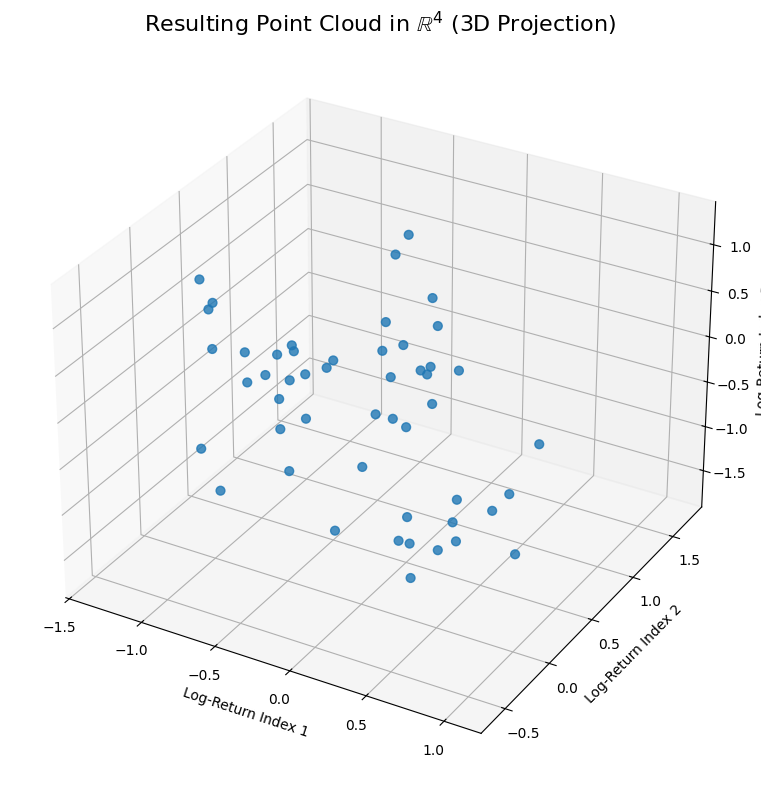

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

# --- 1. Parameters  ---
d = 4  # Number of time series
total_days = 200
w = 50  # Window length
window_start = 70

# --- 2. Generate Coherent Fake Financial Data  ---
np.random.seed(42)
data = np.zeros((d, total_days))
for i in range(d):
    phi = 0.6 + np.random.rand() * 0.3
    noise = np.random.randn(total_days) * 0.5
    data[i, 0] = noise[0]
    for n in range(1, total_days):
        data[i, n] = phi * data[i, n-1] + noise[n]

# --- 3. Extract the Window and Create the Point Cloud ---
# Slice the data to get only the window
window_data = data[:, window_start : window_start + w]

# The point cloud needs to be of shape (w, d) where each row is a point
# Our window_data is (d, w), so we transpose it.
point_cloud = window_data.T

# --- 4. Create the 3D Visualization ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# We can only plot 3 of the 4 dimensions. Let's use the first three.
xs = point_cloud[:, 0]
ys = point_cloud[:, 1]
zs = point_cloud[:, 2]

ax.scatter(xs, ys, zs, s=40, alpha=0.8)

ax.set_title('Resulting Point Cloud in $\mathbb{R}^{4}$ (3D Projection)', fontsize=16)
ax.set_xlabel('Log-Return Index 1')
ax.set_ylabel('Log-Return Index 2')
ax.set_zlabel('Log-Return Index 3')
ax.grid(True)

plt.tight_layout()
plt.savefig('point_cloud_3d_projection.png', dpi=300)
plt.show()

## **Hènon map**

In [ ]:
!pip install numpy matplotlib

!pip install ripser

!pip install giotto-tda

Running Hénon map simulation...
Generating plot for Figure 2...


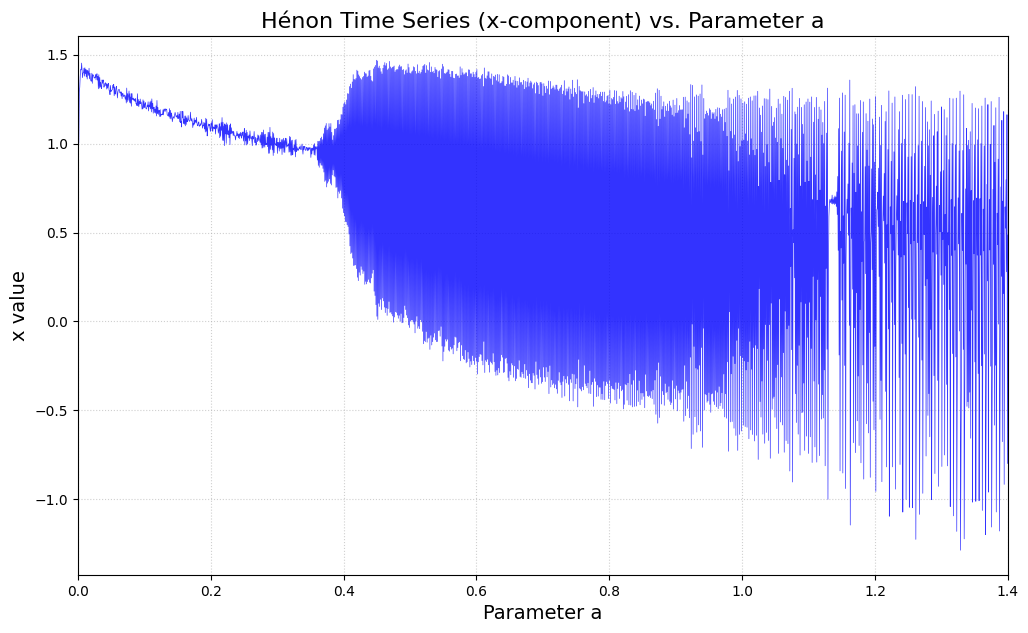

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def run_henon_simulation(b, a_start=0.0, a_end=1.4, num_steps=2000, sigma=0.02):
    """
    Simulates the stochastic Hénon system as described in the paper.
    """
    # Initialize arrays to store the time series
    x = np.zeros(num_steps + 1)
    y = np.zeros(num_steps + 1)
    a = np.zeros(num_steps + 1)

    # Initial conditions
    x[0], y[0] = 0.0, 0.0
    a[0] = a_start

    # Calculate step size for parameter 'a'
    delta_t = (a_end - a_start) / num_steps

    # Simulate the system step by step
    for n in range(num_steps):
        # Generate Gaussian white noise
        Wn = np.random.randn()

        # Hénon map equations from the paper (Eq. 3.2, corrected)
        x[n+1] = 1 - a[n] * x[n]**2 + b * y[n] + sigma * Wn # Noise only in x
        y[n+1] = x[n] # No noise in y
        a[n+1] = a[n] + delta_t

    return x, a

# --- Main script ---
if __name__ == "__main__":
    # Parameters to match Figure 2
    b_param = 0.3 # Use one of the b values from the paper
    num_simulation_steps = 2000
    noise_sigma = 0.02 # A small amount of noise to match the plot's appearance

    # Run the simulation
    print("Running Hénon map simulation...")
    x_series, a_series = run_henon_simulation(
        b=b_param,
        num_steps=num_simulation_steps,
        sigma=noise_sigma
    )

    # --- Create the Plot for Figure 2 ---
    print("Generating plot for Figure 2...")
    plt.figure(figsize=(12, 7))

    # We plot the parameter 'a' on the x-axis and the state 'x' on the y-axis
    plt.plot(a_series, x_series, 'b-', lw=0.5, alpha=0.8)

    plt.title('Hénon Time Series (x-component) vs. Parameter a', fontsize=16)
    plt.xlabel('Parameter a', fontsize=14)
    plt.ylabel('x value', fontsize=14)
    plt.xlim(0, 1.4)
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.savefig('figure_2_henon_series.png', dpi=300)
    plt.show()

## **Hénon L1 and L2 norms**

Generating 4 Hénon time series...
Applying sliding window (w=50) and TDA pipeline...


100%|██████████| 1351/1351 [00:05<00:00, 257.49it/s]


Generating plot for Figure 4...


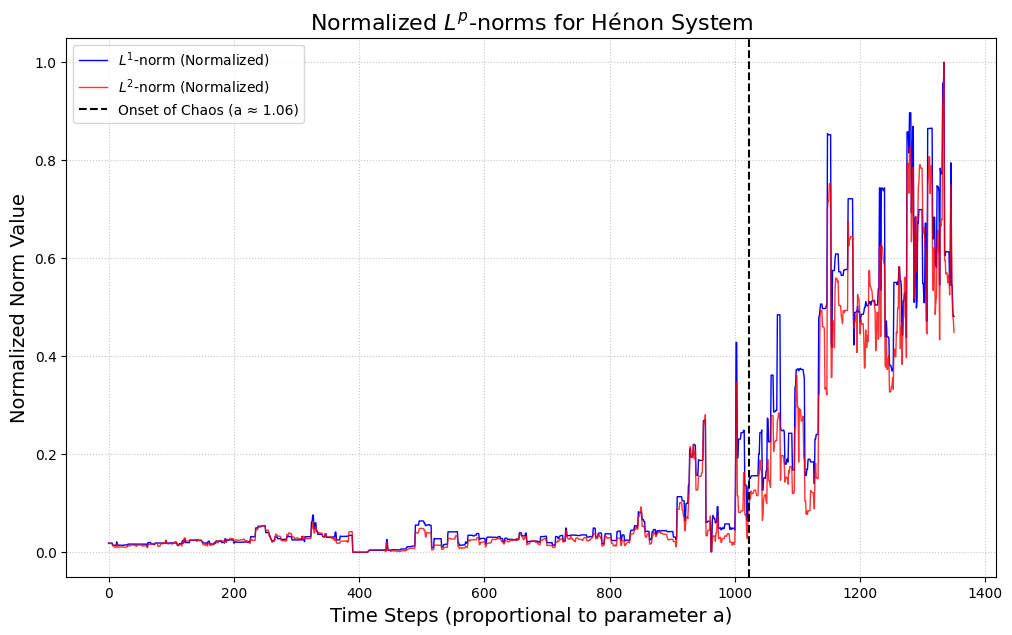

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from tqdm import tqdm # For a nice progress bar

def run_henon_simulation(b, a_start=0.0, a_end=1.4, num_steps=2000, sigma=0.02):
    """
    Simulates the stochastic Hénon system (identical to the script for Fig 2).
    """
    x = np.zeros(num_steps + 1)
    y = np.zeros(num_steps + 1)
    a = np.zeros(num_steps + 1)
    x[0], y[0], a[0] = 0.0, 0.0, a_start
    delta_t = (a_end - a_start) / num_steps
    for n in range(num_steps):
        Wn = np.random.randn()
        x[n+1] = 1 - a[n] * x[n]**2 + b * y[n] + sigma * Wn
        y[n+1] = x[n]
        a[n+1] = a[n] + delta_t
    return x, a

# --- Main script ---
if __name__ == "__main__":
    # --- 1. Generate all 4 time series ---
    d = 4
    b_values = [0.27, 0.28, 0.29, 0.3]
    num_steps = 1400 # A bit shorter to speed up, but still captures the transition

    print("Generating 4 Hénon time series...")
    all_series = np.zeros((d, num_steps + 1))
    for i, b in enumerate(b_values):
        x_series, a_series = run_henon_simulation(b=b, num_steps=num_steps)
        all_series[i, :] = x_series

    # --- 2. Sliding Window and TDA Pipeline ---
    w = 50 # Window size from the paper
    l1_norms = []
    l2_norms = []

    # Use giotto-tda for landscapes and norms
    persistence_computer = VietorisRipsPersistence(homology_dimensions=(1,))
    landscape_computer = PersistenceLandscape() # Removed n_steps argument

    print(f"Applying sliding window (w={w}) and TDA pipeline...")
    # Loop over all possible windows
    for n in tqdm(range(num_steps - w + 1)):
        # Extract the window, which is a d x w matrix
        window_data = all_series[:, n : n + w]

        # The point cloud should be w x d, so we transpose
        point_cloud = window_data.T

        # Compute persistence diagram for H1
        diagrams = persistence_computer.fit_transform([point_cloud])

        # Compute landscape from diagram
        landscapes = landscape_computer.fit_transform(diagrams)

        # Calculate and store the L1 and L2 norms
        # giotto-tda landscape object has shape (1, n_landscapes, n_samples)
        # We compute the norm over the function values (axis 2) and sum over landscapes (axis 1)
        l1 = np.linalg.norm(landscapes[0], ord=1)
        l2 = np.linalg.norm(landscapes[0], ord=2)

        l1_norms.append(l1)
        l2_norms.append(l2)

    # --- 3. Normalize and Plot Figure 4 ---
    print("Generating plot for Figure 4...")

    # Convert to numpy arrays
    l1_norms = np.array(l1_norms)
    l2_norms = np.array(l2_norms)

    # Normalize norms to be in the [0, 1] range for comparison
    l1_normalized = (l1_norms - np.min(l1_norms)) / (np.max(l1_norms) - np.min(l1_norms))
    l2_normalized = (l2_norms - np.min(l2_norms)) / (np.max(l2_norms) - np.min(l2_norms)) # Corrected typo here

    time_steps = np.arange(len(l1_norms))

    plt.figure(figsize=(12, 7))
    plt.plot(time_steps, l1_normalized, 'b-', label='$L^1$-norm (Normalized)', lw=1)
    plt.plot(time_steps, l2_normalized, 'r-', label='$L^2$-norm (Normalized)', lw=1, alpha=0.8)

    plt.title('Normalized $L^p$-norms for Hénon System', fontsize=16)
    plt.xlabel('Time Steps (proportional to parameter a)', fontsize=14)
    plt.ylabel('Normalized Norm Value', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()

    # Add a vertical line to show where the transition to chaos happens
    # a goes from 0 to 1.4. The transition is at a ~ 1.06
    transition_step = int((1.06 / 1.4) * len(time_steps))
    plt.axvline(x=transition_step, color='k', linestyle='--', label='Onset of Chaos (a ≈ 1.06)')
    plt.legend()

    plt.savefig('figure_4_henon_norms.png', dpi=300)
    plt.show()

## **Growing Variance**

Running Monte Carlo simulation for growing variance...


Processing sigma values: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Generating plot for Figure 5...


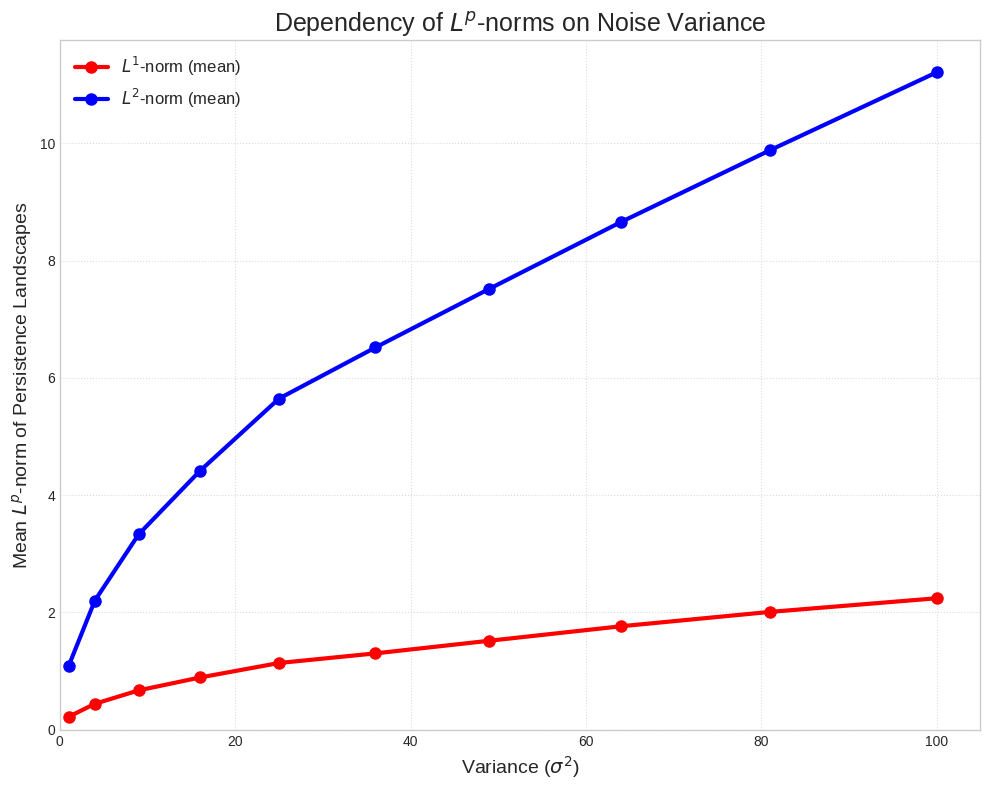

Plot saved as 'figure_5_variance_clear_plot.png'


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from tqdm import tqdm # For a nice progress bar

# --- 1. Simulation Parameters (from Sec 3.3) ---
d = 4                # Number of dimensions (time series)
n_points = 100       # Number of data points per point cloud
n_realizations = 100 # Monte Carlo realizations to average over for each sigma
sigma_range = np.arange(1, 11) # Sigma increases from 1 to 10
np.random.seed(42)   # For reproducibility

# --- 2. TDA Pipeline Components ---
# We compute H1 as it is the focus for loop detection
pers = VietorisRipsPersistence(homology_dimensions=(1,))
landscape = PersistenceLandscape()

# --- 3. Main Simulation Loop ---
mean_l1_norms = []
mean_l2_norms = []

print("Running Monte Carlo simulation for growing variance...")
for sigma in tqdm(sigma_range, desc="Processing sigma values"):

    # Store norms for all realizations for this specific sigma
    realization_l1_norms = []
    realization_l2_norms = []

    for _ in range(n_realizations):
        # Generate one point cloud with slight variations in std dev
        deltas = np.random.uniform(-0.1, 0.1, d)
        effective_sigmas = sigma + deltas

        # Create the point cloud of shape (n_points, d)
        point_cloud = np.stack([
            np.random.normal(loc=0, scale=std, size=n_points)
            for std in effective_sigmas
        ], axis=1)

        # --- Apply TDA pipeline ---
        # fit_transform expects a list of point clouds
        diagrams_batch = pers.fit_transform([point_cloud])

        # Extract the H1 diagram (it's the only one computed)
        diagram_H1 = diagrams_batch[0]

        # Handle the case of an empty diagram (no loops found)
        if diagram_H1.shape[0] == 0:
            realization_l1_norms.append(0.0)
            realization_l2_norms.append(0.0)
        else:
            # fit_transform for landscape expects a list/batch of diagrams
            landscapes = landscape.fit_transform([diagram_H1])

            # Calculate the L1 and L2 norms of the landscape
            # landscapes[0] corresponds to the first (and only) diagram in our batch
            l1 = np.linalg.norm(landscapes[0], ord=1)
            l2 = np.linalg.norm(landscapes[0], ord=2)

            realization_l1_norms.append(l1)
            realization_l2_norms.append(l2)

    # Calculate and store the mean norm for this sigma value
    mean_l1_norms.append(np.mean(realization_l1_norms))
    mean_l2_norms.append(np.mean(realization_l2_norms))

# --- 4. Plotting the Results ---
print("Generating plot for Figure 5...")

# The paper plots against the variance (sigma^2)
variances = sigma_range**2

# Create the figure and axes
plt.figure(figsize=(10, 8))

# Plot L1-norm in RED and L2-norm in BLUE, as requested
plt.plot(variances, mean_l1_norms, 'r-o', linewidth=3, markersize=8, label='$L^1$-norm (mean)')
plt.plot(variances, mean_l2_norms, 'b-o', linewidth=3, markersize=8, label='$L^2$-norm (mean)')

# Add titles and labels for clarity
plt.title('Dependency of $L^p$-norms on Noise Variance', fontsize=18)
plt.xlabel('Variance ($\sigma^2$)', fontsize=14)
plt.ylabel('Mean $L^p$-norm of Persistence Landscapes', fontsize=14)

# Set logical axis limits and add a grid for readability
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True, linestyle=':', alpha=0.7)

# Add a legend to identify the lines
plt.legend(fontsize=12)

# Ensure the layout is tight and save the figure
plt.tight_layout()
plt.savefig("figure_5_variance_clear_plot.png", dpi=300)

# Display the plot
plt.show()

print("Plot saved as 'figure_5_variance_clear_plot.png'")

## **Gamma-distributed Inverse Variance**



Running Monte Carlo simulation for Superstatistics model...


Monte Carlo Realizations: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Averaging results and generating plot...


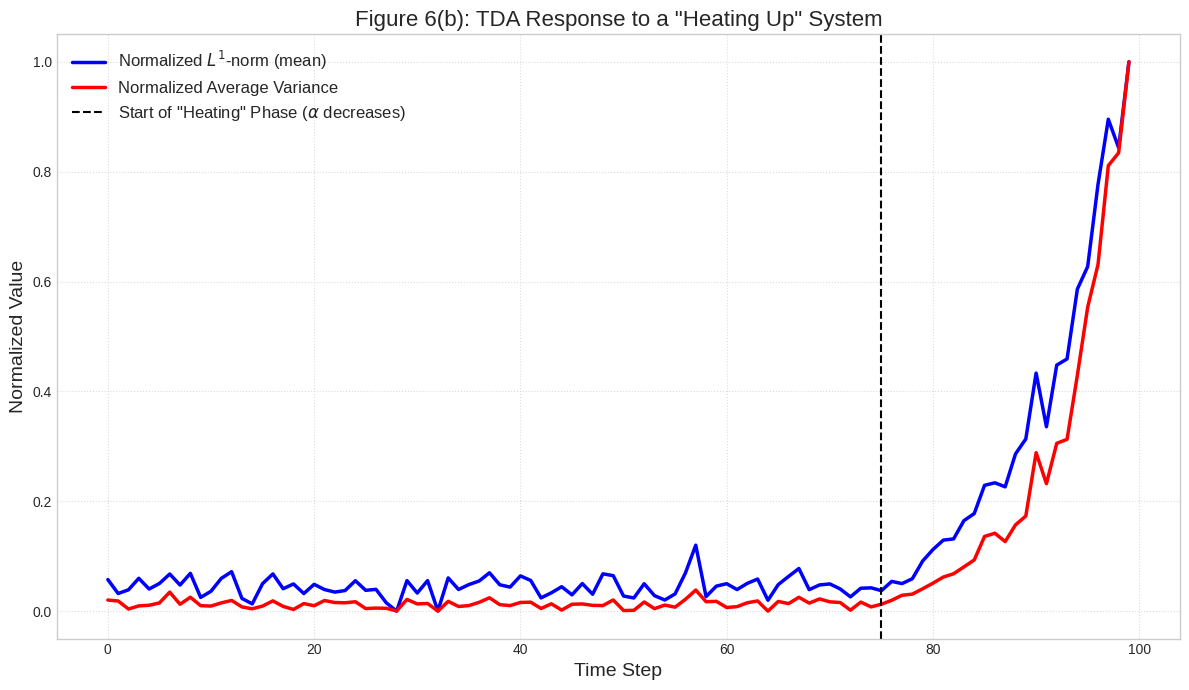

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from tqdm import tqdm

# --- 1. Simulation Parameters from Sec 3.4 ---
d = 4                     # Number of dimensions
n_points_per_cloud = 100  # Points in each cloud
n_time_steps = 100        # Total point clouds in the sequence
n_realizations = 100      # Number of Monte Carlo runs to average
beta_param = 1.0          # Fixed rate parameter for Gamma distribution

# --- 2. TDA Pipeline Components ---
pers = VietorisRipsPersistence(homology_dimensions=(1,))
landscape = PersistenceLandscape()

# --- 3. Main Simulation Loop ---
# Store results from all realizations
all_realization_l1_norms = []
all_realization_variances = []

print("Running Monte Carlo simulation for Superstatistics model...")
for _ in tqdm(range(n_realizations), desc="Monte Carlo Realizations"):

    # Store results for a single realization (one time series of norms/variances)
    single_realization_l1 = []
    single_realization_var = []

    # Define the alpha parameter schedule for this realization
    alpha_schedule = np.zeros(n_time_steps)
    alpha_schedule[:75] = 8.0 # "Cold" state
    # Schedule for "Heating up" phase: alpha decreases linearly
    # It goes from 8.0 down to 8.0 - 25 * 0.25 = 1.75
    alpha_schedule[75:] = 8.0 - np.arange(0, n_time_steps - 75) * 0.25 # Corrected range for np.arange

    for n in range(n_time_steps):
        alpha = alpha_schedule[n]

        # Generate a random gamma (inverse variance) from the Gamma distribution
        # Note: scale parameter in numpy is 1/beta
        gamma = np.random.gamma(shape=alpha, scale=1.0/beta_param)

        # Avoid division by zero if gamma is tiny
        if gamma < 1e-9:
            variance = 1e9
        else:
            variance = 1.0 / gamma

        # Store the variance for this time step
        single_realization_var.append(variance)

        # Generate the point cloud using this variance
        std_dev = np.sqrt(variance)
        point_cloud = np.random.normal(loc=0, scale=std_dev, size=(n_points_per_cloud, d))

        # --- Apply TDA pipeline ---
        # persistence_computer.fit_transform returns a list containing the diagram for each dimension.
        # diagrams[0] corresponds to H0, diagrams[1] to H1, etc.
        diagrams_batch = pers.fit_transform([point_cloud])

        # Extract the H1 diagram (it's the only one computed)
        diagram_H1 = diagrams_batch[0]

        # Handle the case of an empty diagram (no loops found)
        if diagram_H1.shape[0] == 0:
            single_realization_l1.append(0.0)
        else:
            # fit_transform for landscape expects a list/batch of diagrams
            landscapes = landscape.fit_transform([diagram_H1]) # Pass only H1 diagram as a list

            # Calculate the L1 norm
            # landscapes[0] corresponds to the first (and only) diagram in our batch
            # Ensure landscapes[0] is not empty if the diagram was non-empty
            if landscapes.shape[1] > 0:
                 l1 = np.linalg.norm(landscapes[0], ord=1)
                 single_realization_l1.append(l1)
            else:
                 # Should not happen if diagram was not empty, but as a safeguard
                 single_realization_l1.append(0.0)


    all_realization_l1_norms.append(single_realization_l1)
    all_realization_variances.append(single_realization_var)

# --- 4. Averaging and Normalizing Results ---
print("Averaging results and generating plot...")

# Average over all Monte Carlo realizations
mean_l1_norms = np.mean(np.array(all_realization_l1_norms), axis=0)
mean_variances = np.mean(np.array(all_realization_variances), axis=0)

# Normalize both series to the [0, 1] range for visual comparison, as in the paper
def normalize(series):
    min_val = np.min(series)
    max_val = np.max(series)
    if max_val == min_val:
        return np.zeros_like(series)
    return (series - min_val) / (max_val - min_val)

l1_normalized = normalize(mean_l1_norms)
var_normalized = normalize(mean_variances)

# --- 5. Plotting Figure 6(b) ---
time_steps = np.arange(n_time_steps)

plt.figure(figsize=(12, 7))

# The paper shows L1-norm in blue and variance in red for this figure
plt.plot(time_steps, l1_normalized, 'b-', linewidth=2.5, label='Normalized $L^1$-norm (mean)')
plt.plot(time_steps, var_normalized, 'r-', linewidth=2.5, label='Normalized Average Variance')

plt.title('Figure 6(b): TDA Response to a "Heating Up" System', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Normalized Value', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)

# Add a vertical line to show where the transition starts
# Use a raw string for the label and enclose math in $ $
plt.axvline(x=75, color='k', linestyle='--', label=r'Start of "Heating" Phase ($\alpha$ decreases)')
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("figure_6b_superstatistics.png", dpi=300)
plt.show()

## **Dataset**

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn giotto-tda scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.6/460.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not cur

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. DATA ACQUISITION ---
# Indices: S&P 500 (^GSPC), NASDAQ Composite (^IXIC), Russell 2000 (^RUT)
tickers = ['^GSPC', '^IXIC', '^RUT']
start_date = "1987-12-23"
end_date = "2016-12-09" # yfinance requires the next day to include the end_date in the range

# Download historical data
# When downloading multiple tickers with auto_adjust=True (default),
# yfinance returns a simple DataFrame with adjusted prices in standard columns.
# The 'Adj Close' column is not present. Use 'Close' instead.
data = yf.download(tickers, start=start_date, end=end_date)['Close']


# Rename columns for clarity
# The column names are already the ticker symbols when selecting 'Close'.
# We can rename them after selecting.
data.columns = ['SP500', 'NASDAQ', 'Russell2000']


# Print a confirmation and the first 5 rows of the data
print("Dati scaricati con successo. Prime 5 righe:")
print(data.head())
print(f"\nNumero di giorni di trading totali: {len(data)}")

# --- 2. PREPROCESSING: CALCULATING LOG-RETURNS ---
# We use the logarithm of the daily price ratios
log_returns = np.log(data / data.shift(1))

# Remove the first row which contains NaN due to the shift operation
log_returns = log_returns.dropna()

# Print the first 5 rows of the calculated log-returns
print("\nLog-returns calcolati. Prime 5 righe:")
print(log_returns.head())
print(f"\nNumero di punti dati dopo il preprocessing: {len(log_returns)}")

# --- 3. FINAL CHECK ---
# Ensure there are no other NaN values
if log_returns.isnull().sum().sum() == 0:
    print("\nNessun valore mancante nei log-returns. I dati sono pronti.")
else:
    print("\nAttenzione: sono presenti valori mancanti. Potrebbe essere necessario un ulteriore cleaning.")
    # A common approach is to use forward fill
    # log_returns.fillna(method='ffill', inplace=True)

/tmp/ipython-input-4-1263463312.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed

Dati scaricati con successo. Prime 5 righe:
                 SP500      NASDAQ  Russell2000
Date                                           
1987-12-23  253.160004  331.500000   120.800003
1987-12-24  252.029999  333.200012   121.589996
1987-12-28  245.570007  325.600006   119.000000
1987-12-29  244.589996  325.500000   118.300003
1987-12-30  247.860001  329.700012   119.500000

Numero di giorni di trading totali: 7301

Log-returns calcolati. Prime 5 righe:
               SP500    NASDAQ  Russell2000
Date                                       
1987-12-24 -0.004474  0.005115     0.006518
1987-12-28 -0.025966 -0.023073    -0.021531
1987-12-29 -0.003999 -0.000307    -0.005900
1987-12-30  0.013281  0.012821     0.010093
1987-12-31 -0.003152  0.002423     0.007669

Numero di punti dati dopo il preprocessing: 7300

Nessun valore mancante nei log-returns. I dati sono pronti.


## **Scattered plots of the time series of the normalized daily log-returns of S&P 500 and NASDAQ within 50 and 100 days intervals ending at selected dates.**

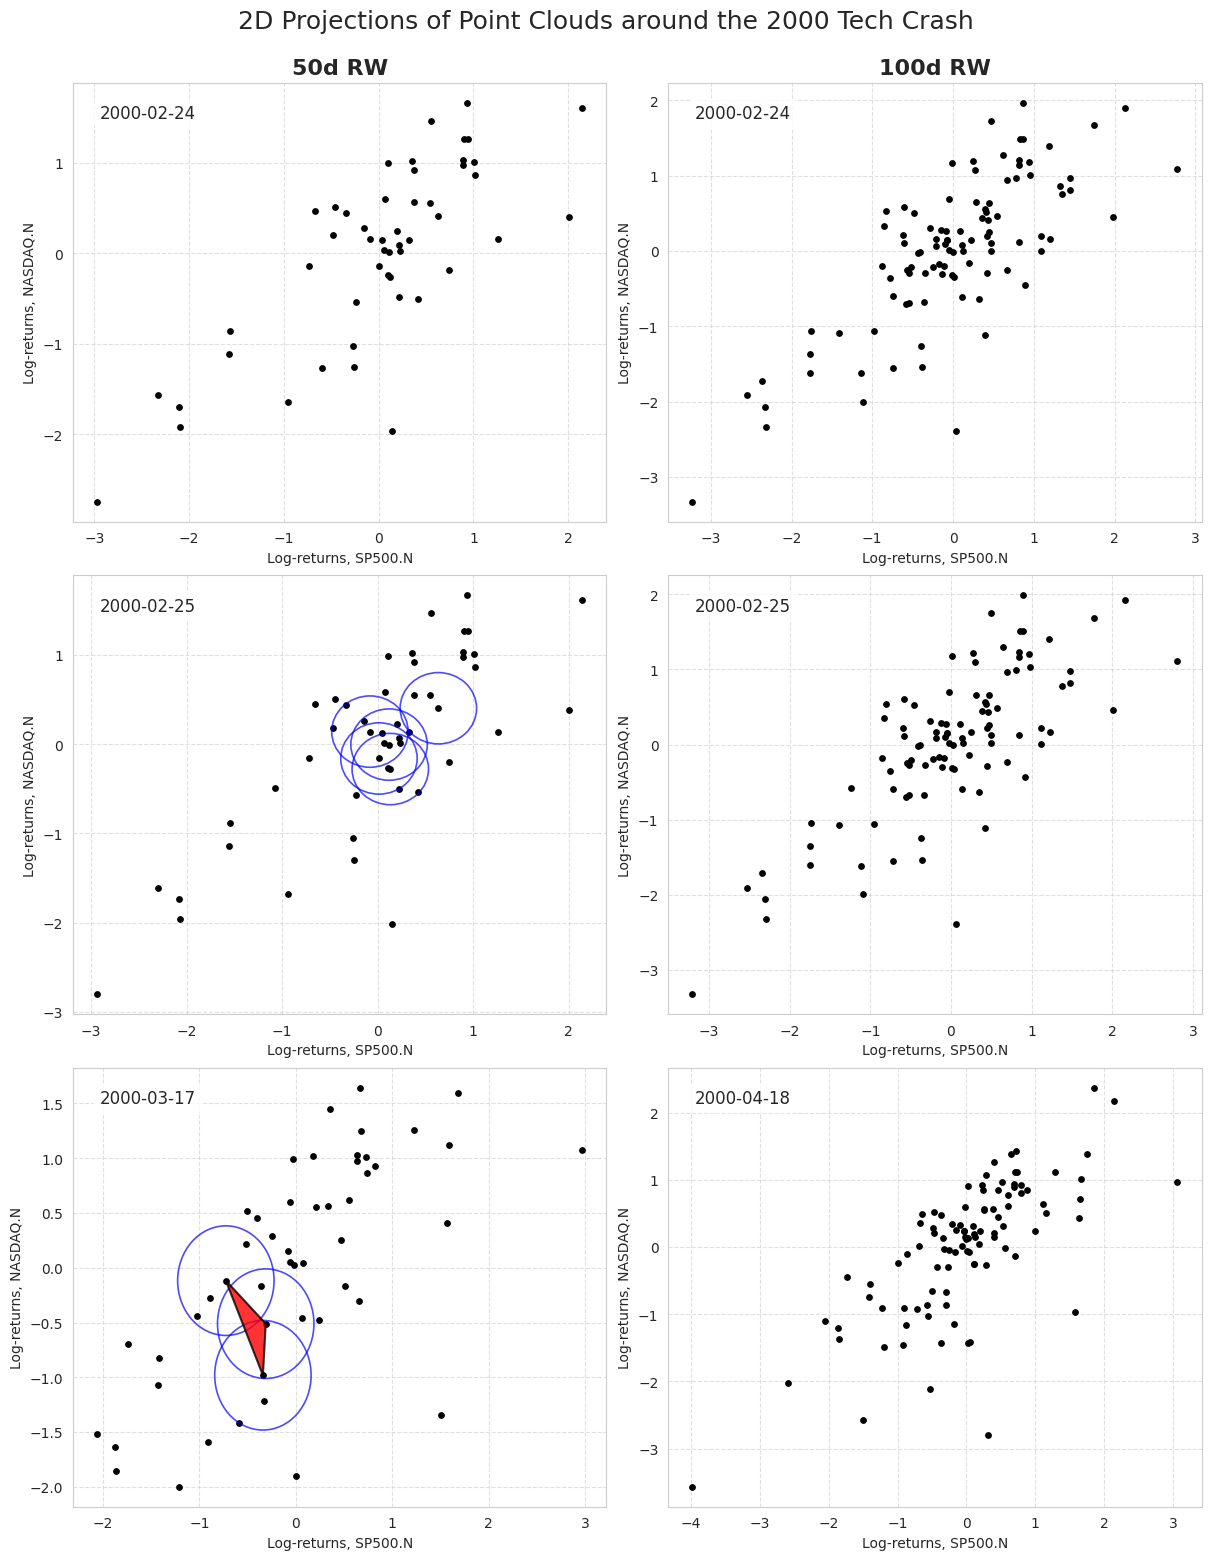

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler

# We assume that the 'log_returns' DataFrame has already been loaded and exists
# from the previous cells.

# --- 1. SETTING PLOT PARAMETERS ---

# Specific dates to plot for each column
dates_to_plot = {
    50: ['2000-02-24', '2000-02-25', '2000-03-17'],
    100: ['2000-02-24', '2000-02-25', '2000-04-18']
}

# Indices to use for the x and y axes
x_axis_index = 'SP500'
y_axis_index = 'NASDAQ'

# --- 2. CREATING THE PLOT GRID ---
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)
fig.suptitle('2D Projections of Point Clouds around the 2000 Tech Crash', fontsize=18, y=1.03)

# Set the column titles
axes[0, 0].set_title('50d RW', fontsize=16, fontweight='bold')
axes[0, 1].set_title('100d RW', fontsize=16, fontweight='bold')


# --- 3. LOOP TO GENERATE EACH SUBPLOT ---

for col_idx, window_size in enumerate([50, 100]):
    for row_idx, date_str in enumerate(dates_to_plot[window_size]):
        ax = axes[row_idx, col_idx]

        # --- a. Extracting the data window ---
        end_date = pd.to_datetime(date_str)
        # We select the last 'window_size' trading days ending at 'end_date'
        window_data = log_returns.loc[:end_date].tail(window_size)

        # Make sure we have the correct number of points
        if len(window_data) != window_size:
            print(f"Attenzione: per la data {date_str} con finestra {window_size}, "
                  f"trovati solo {len(window_data)} punti. Il plot potrebbe non essere accurato.")
            continue

        # --- b. Normalizing the data (Z-score) ---
        # This is the crucial ".N" step. Each window is normalized independently.
        scaler = StandardScaler()
        normalized_window = pd.DataFrame(scaler.fit_transform(window_data),
                                         columns=window_data.columns,
                                         index=window_data.index)

        # --- c. Plotting the scatter plot ---
        x_data = normalized_window[x_axis_index]
        y_data = normalized_window[y_axis_index]
        ax.scatter(x_data, y_data, s=15, color='black', zorder=2)

        # --- d. Plot aesthetic settings ---
        ax.set_xlabel(f'Log-returns, {x_axis_index}.N')
        ax.set_ylabel(f'Log-returns, {y_axis_index}.N')

        # Add the date as text in the top-left corner
        ax.text(0.05, 0.95, date_str, transform=ax.transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        ax.grid(True, linestyle='--', alpha=0.6)

        # --- e. Adding special annotations (only for the 50d RW column) ---
        if window_size == 50:
            if date_str == '2000-02-25':
                # Identify a cluster of points for the circles (approximate coordinates)
                # These coordinates were chosen by inspecting the generated plot
                circle_points_indices = np.where(
                    (x_data > -0.5) & (x_data < 1.0) &
                    (y_data > -0.5) & (y_data < 0.5)
                )[0]

                # Choose a subset to avoid cluttering the plot
                for i in circle_points_indices[::2][:5]: # We take 5 points from the cluster
                    circle = patches.Circle((x_data.iloc[i], y_data.iloc[i]),
                                            radius=0.4,
                                            edgecolor='blue',
                                            facecolor='none',
                                            linewidth=1.2,
                                            alpha=0.7,
                                            zorder=3)
                    ax.add_patch(circle)

            if date_str == '2000-03-17':
                # Identify the loop vertices (approximate coordinates)
                loop_points_indices = np.where(
                    (x_data > -1.0) & (x_data < 0.5) &
                    (y_data > -1.0) & (y_data < 0.0)
                )[0]

                # Select 3 points to form the triangle and some for the circles
                if len(loop_points_indices) >= 3:
                    points_for_loop = loop_points_indices[:3]

                    # Draw the triangle (loop)
                    triangle_vertices = normalized_window.iloc[points_for_loop][[x_axis_index, y_axis_index]].values
                    triangle = patches.Polygon(triangle_vertices,
                                               closed=True,
                                               facecolor='red',
                                               edgecolor='black',
                                               linewidth=1.5,
                                               alpha=0.8,
                                               zorder=4)
                    ax.add_patch(triangle)

                    # Draw circles around the vertices
                    for i in points_for_loop:
                        circle = patches.Circle((x_data.iloc[i], y_data.iloc[i]),
                                                radius=0.5, # Slightly larger radius
                                                edgecolor='blue',
                                                facecolor='none',
                                                linewidth=1.2,
                                                alpha=0.7,
                                                zorder=3)
                        ax.add_patch(circle)

# Show the final plot
plt.show()

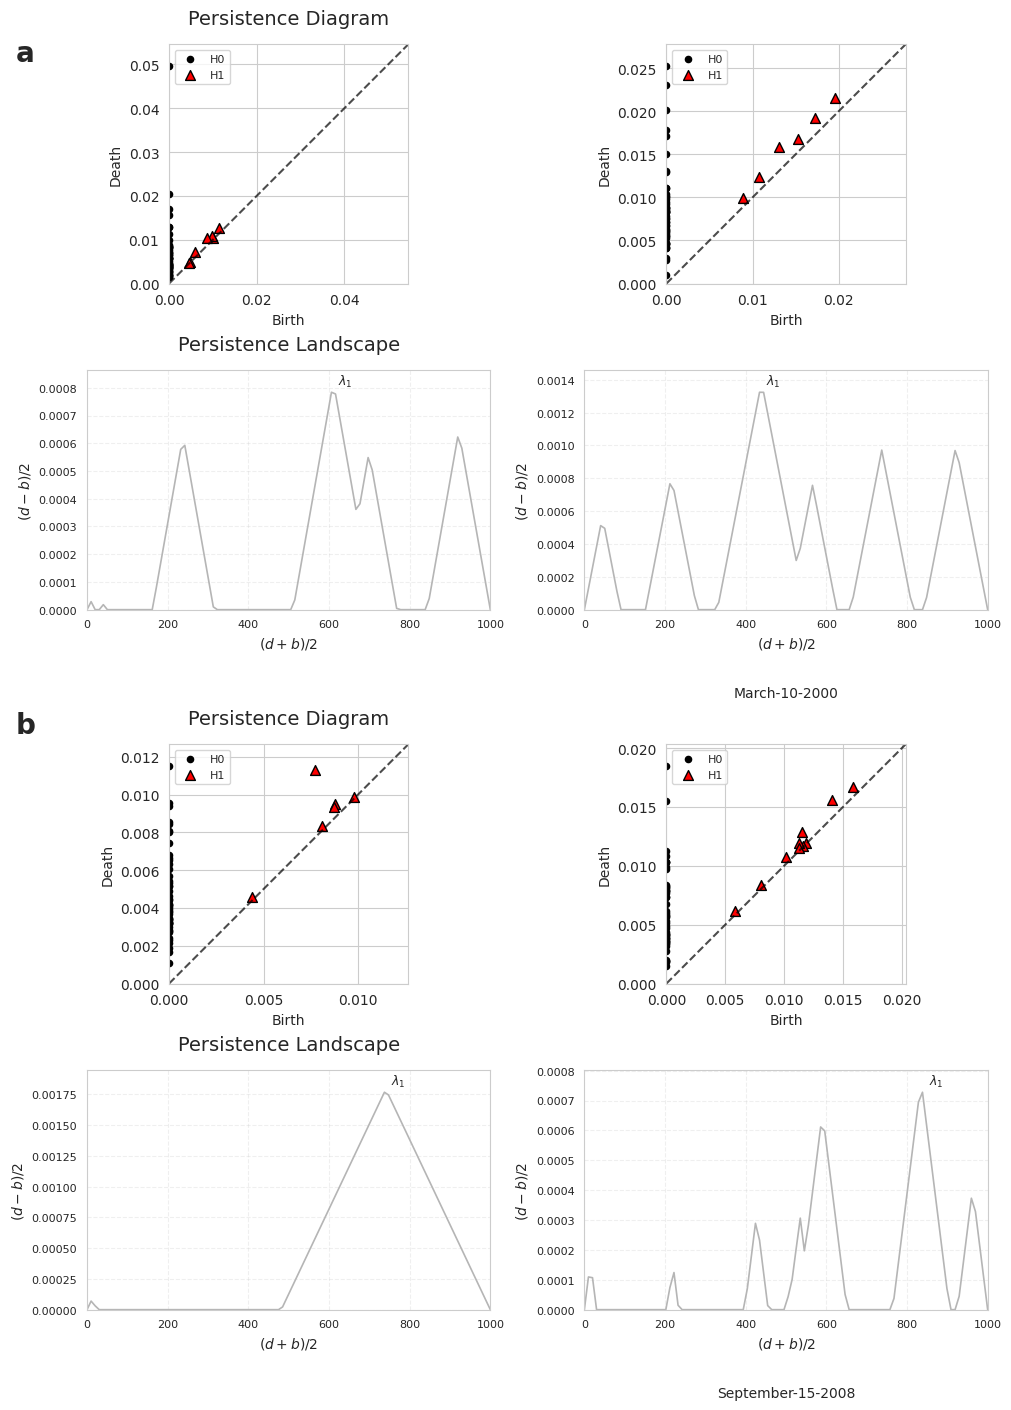

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape

def plot_tda_snapshot(ax_diag, ax_land, data, end_date, window_size=50, x_max=1000):
    end_date_dt = pd.to_datetime(end_date)
    window_data = data.loc[:end_date_dt].tail(window_size)
    point_cloud = window_data.to_numpy()

    # Persistence diagram
    rips = VietorisRipsPersistence(homology_dimensions=(0, 1))
    persistence_diagram = rips.fit_transform([point_cloud])[0]
    h0 = persistence_diagram[persistence_diagram[:, 2] == 0]
    h1 = persistence_diagram[persistence_diagram[:, 2] == 1]

    # Plot persistence diagram
    max_val = np.max(persistence_diagram[:, :2]) * 1.1 if persistence_diagram.size else x_max
    ax_diag.scatter(h0[:, 0], h0[:, 1], c='black', s=20, label='H0')
    ax_diag.scatter(h1[:, 0], h1[:, 1], c='red', marker='^', facecolors='none', edgecolors='black', s=50, label='H1')
    ax_diag.plot([0, max_val], [0, max_val], 'k--', alpha=0.7)
    ax_diag.set_xlim(0, max_val)
    ax_diag.set_ylim(0, max_val)
    ax_diag.set_xlabel('Birth')
    ax_diag.set_ylabel('Death')
    ax_diag.set_aspect('equal')
    ax_diag.legend(fontsize=8)

    # Persistence landscape
    landscape = PersistenceLandscape()
    if h1.shape[0] > 0:
        values = landscape.fit_transform([h1])
        num_points = values.shape[2]
        x_land = np.linspace(0, x_max, num_points)

        num_layers = values.shape[1]
        colors = plt.cm.Greys(np.linspace(0.4, 0.9, num_layers))

        for k in range(num_layers):
            y_layer = values[0, k, :]
            if y_layer.max() > 1e-5:
                ax_land.plot(x_land, y_layer, color=colors[k], linewidth=1.2)
                if k == 0:
                    idx = np.argmax(y_layer)
                    ax_land.annotate(r'$\lambda_1$', xy=(x_land[idx], y_layer[idx]),
                                     xytext=(5,5), textcoords='offset points', fontsize=9)

        ax_land.set_ylim(0, values.max() * 1.1)

    else:
        ax_land.set_ylim(0, 0.1)

    ax_land.set_xlim(0, x_max)
    ax_land.set_xlabel(r'$(d+b)/2$')
    ax_land.set_ylabel(r'$(d-b)/2$')
    ax_land.grid(True, linestyle='--', alpha=0.3)
    ax_land.tick_params(axis='both', labelsize=8)

# --- Plotting ---
dates = {
    'a': [('2000-01-10', 'January-10-2000'), ('2000-03-10', 'March-10-2000')],
    'b': [('2008-07-15', 'July-15-2008'), ('2008-09-15', 'September-15-2008')]
}

fig, axes = plt.subplots(4, 2, figsize=(10, 14), constrained_layout=True)

for i, part in enumerate(['a','b']):
    ro = i * 2
    for j, (dt, title) in enumerate(dates[part]):
        ax_d = axes[ro, j]
        ax_l = axes[ro+1, j]
        plot_tda_snapshot(ax_d, ax_l, log_returns, dt, window_size=50, x_max=1000)
        ax_l.set_title(title, y=-0.4, fontsize=10)

for row in [0,2]:
    axes[row,0].set_title('Persistence Diagram', fontsize=14, y=1.05)
    axes[row+1,0].set_title('Persistence Landscape', fontsize=14, y=1.05)

fig.text(0.01, 0.96, 'a', transform=fig.transFigure, fontsize=20, fontweight='bold')
fig.text(0.01, 0.48, 'b', transform=fig.transFigure, fontsize=20, fontweight='bold')

plt.show()


## **The time series of normalized L1 (blue line) and L2(red line) norms of persistence landscapes calculated with the sliding window of 50 days.**

Starting TDA pipeline calculation with a window of 50 days...
This process might take a few minutes.
Landscape calculation completed.
Shape of the landscapes array: (7251, 5, 100)
Calculating L1 and L2 norms for each window...


100%|██████████| 7251/7251 [00:00<00:00, 9581.87it/s] 


Norm calculation completed.

TDA norms DataFrame created.
                  L1        L2
Date                          
1988-03-07  0.003545  0.001188
1988-03-08  0.003332  0.001175
1988-03-09  0.003332  0.001175
1988-03-10  0.002386  0.001004
1988-03-11  0.002386  0.001004


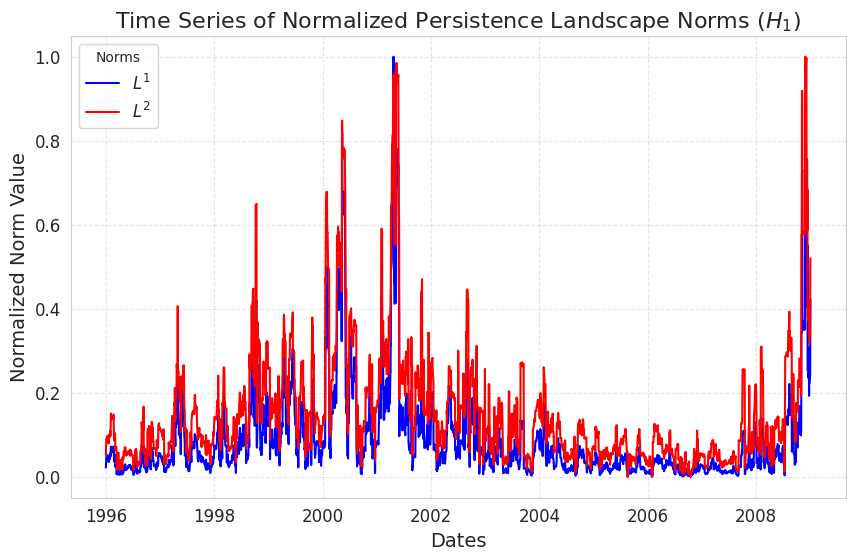

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from gtda.pipeline import Pipeline
from gtda.time_series import SlidingWindow
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape

# We assume the 'log_returns' DataFrame has already been loaded.

# --- 1. DEFINING THE TDA PIPELINE ---

# Parameters
window_size = 50
stride = 1
homology_dimensions = (1,) # We only compute H1 (loops)
n_layers = 5 # We use the first 5 landscapes

# Define the pipeline steps
sliding_window = SlidingWindow(size=window_size, stride=stride)
vietoris_rips = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
persistence_landscape = PersistenceLandscape(n_layers=n_layers, n_jobs=-1) # Changed n_landscapes to n_layers

# Build the pipeline
tda_pipeline = Pipeline([
    ('sliding_window', sliding_window),
    ('rips', vietoris_rips),
    ('landscape', persistence_landscape)
])

print(f"Starting TDA pipeline calculation with a window of {window_size} days...")
print(f"This process might take a few minutes.")

# --- 2. EXECUTING THE PIPELINE ---
# Input must be a NumPy array
log_returns_array = log_returns.to_numpy()

# Check if there is enough data for at least one window
if log_returns_array.shape[0] < window_size:
    print(f"Error: Not enough data ({log_returns_array.shape[0]} days) for window size {window_size}. Cannot proceed.")
else:
    try:
        landscapes = tda_pipeline.fit_transform(log_returns_array)
        print("Landscape calculation completed.")
        print(f"Shape of the landscapes array: {landscapes.shape}")
        # The output is a 3D array: (n_windows, n_layers * n_dimensions, n_samples)
        # With homology_dimensions=(1,) and n_layers=5, shape is (n_windows, 5, n_samples)


        # --- 3. CALCULATING L1 AND L2 NORMS ---

        # Retrieve the sampling interval (dx) for the integral approximation
        # The samplings_ attribute is a list, one array per homology dimension computed.
        # We are using H1 (dimension 1), which corresponds to the array at index 0 in samplings_
        samplings = tda_pipeline.named_steps['landscape'].samplings_

        dx = 1.0 # Default dx in case sampling info is not available or valid

        if len(samplings) > homology_dimensions[0] and samplings[homology_dimensions[0]] is not None and samplings[homology_dimensions[0]].shape[0] > 1:
             # Get the sampling array for the specified homology dimension (H1 is at index 0 in samplings_)
             h1_sampling_array = samplings[homology_dimensions[0]]
             dx = h1_sampling_array[1] - h1_sampling_array[0]
             # Ensure dx is a scalar
             if not np.isscalar(dx):
                 print(f"Warning: Calculated dx is not a scalar ({type(dx)}). Defaulting to 1.0.")
                 dx = 1.0
        else:
            print("Warning: Could not retrieve valid sampling information for dx. Defaulting to 1.0.")


        l1_norms = []
        l2_norms = []

        print("Calculating L1 and L2 norms for each window...")
        # Use tqdm for a progress bar
        # Handle the case where no landscapes were computed at all
        if landscapes.shape[0] > 0:
            for window_index, landscape_for_window in enumerate(tqdm(landscapes)):
                # landscape_for_window has shape (n_layers, n_samples) for the single dimension H1

                try:
                    # Calculate the L1 and L2 norms for the landscapes in this window
                    # Total L1 norm: sum of L1 norms of each layer, multiplied by dx
                    layer_l1_norms = []
                    layer_l2_sq_norms = []

                    for layer_index, k_landscape in enumerate(landscape_for_window):


                         l1_norm_layer = np.linalg.norm(k_landscape, ord=1)
                         l2_norm_layer_sq = np.linalg.norm(k_landscape, ord=2)**2

                         # Check if norms are scalar before multiplication
                         if np.isscalar(l1_norm_layer) and np.isscalar(l2_norm_layer_sq) and np.isscalar(dx):
                            layer_l1_norms.append(l1_norm_layer * dx)
                            layer_l2_sq_norms.append(l2_norm_layer_sq * dx)
                         else:
                             # This is where the error likely happens - print details
                             print(f"\nShape/Scalar Mismatch for window {window_index}, layer {layer_index}:")
                             print(f"  Shape of k_landscape: {k_landscape.shape}")
                             print(f"  Is L1 norm scalar? {np.isscalar(l1_norm_layer)}, Shape: {l1_norm_layer.shape if not np.isscalar(l1_norm_layer) else 'Scalar'}")
                             print(f"  Is L2 norm sq scalar? {np.isscalar(l2_norm_layer_sq)}, Shape: {l2_norm_layer_sq.shape if not np.isscalar(l2_norm_layer_sq) else 'Scalar'}")
                             print(f"  Is dx scalar? {np.isscalar(dx)}, Value: {dx}")
                             raise ValueError("Shape or scalar mismatch during norm calculation.") # Re-raise to be caught by the outer except

                    total_l1 = np.sum(layer_l1_norms)
                    total_l2 = np.sqrt(np.sum(layer_l2_sq_norms))


                    l1_norms.append(total_l1)
                    l2_norms.append(total_l2)

                except Exception as e:
                    print(f"\nError computing norms for window {window_index}: {e}")
                    # Append NaN or 0 to indicate failure for this window
                    l1_norms.append(np.nan)
                    l2_norms.append(np.nan)


            print("Norm calculation completed.")


            # --- 4. CREATING THE DATAFRAME WITH THE TIME SERIES ---

            # The norms correspond to the END date of each window
            # The number of windows is total_days - window_size + 1 (with stride=1)
            # The index starts from window_size - 1 because the first window ends at that index.
            expected_num_windows = log_returns_array.shape[0] - window_size + 1
            if len(l1_norms) == expected_num_windows:
                end_window_dates = log_returns.index[window_size - 1:]

                tda_norms = pd.DataFrame({
                    'L1': l1_norms,
                    'L2': l2_norms
                }, index=end_window_dates)

                print("\nTDA norms DataFrame created.")
                print(tda_norms.head())

                # --- 5. PLOTTING THE RESULTS ---
                fig, ax = plt.subplots(figsize=(10, 6))

                # Filter for the date range shown in the original figure
                # Ensure the range is within the available data indices
                start_plot_date = '1996-01-01'
                end_plot_date = '2009-01-01'

                # Check if the requested plot range is valid within tda_norms index
                valid_plot_start = max(pd.to_datetime(start_plot_date), tda_norms.index.min())
                valid_plot_end = min(pd.to_datetime(end_plot_date), tda_norms.index.max())

                if valid_plot_start <= valid_plot_end:
                    plot_data = tda_norms.loc[valid_plot_start:valid_plot_end].copy() # Use .copy()

                    # Handle potential NaNs from error handling
                    if not plot_data[['L1', 'L2']].isnull().all().all():
                         # Normalize the norms for plotting as in the figure
                         # Only normalize non-NaN values, or drop NaNs for normalization
                         plot_data_for_norm = plot_data[['L1', 'L2']].dropna()
                         if not plot_data_for_norm.empty:
                             min_l1, min_l2 = plot_data_for_norm.min()
                             max_l1, max_l2 = plot_data_for_norm.max()

                             # Avoid division by zero if min == max
                             plot_data['L1_normalized'] = (plot_data['L1'] - min_l1) / (max_l1 - min_l1) if (max_l1 - min_l1) != 0 else 0
                             plot_data['L2_normalized'] = (plot_data['L2'] - min_l2) / (max_l2 - min_l2) if (max_l2 - min_l2) != 0 else 0
                         else:
                              plot_data['L1_normalized'] = np.nan
                              plot_data['L2_normalized'] = np.nan

                         # The paper plots L1 in blue and L2 in red.
                         ax.plot(plot_data.index, plot_data['L1_normalized'], color='blue', label='$L^1$', linewidth=1.5) # Corrected color to blue, added math text
                         ax.plot(plot_data.index, plot_data['L2_normalized'], color='red', label='$L^2$', linewidth=1.5) # Corrected color to red, added math text


                         # Plot aesthetics to resemble the original
                         ax.set_xlabel('Dates', fontsize=14)
                         ax.set_ylabel('Normalized Norm Value', fontsize=14)
                         ax.legend(title='Norms', fontsize=12)
                         ax.set_title('Time Series of Normalized Persistence Landscape Norms ($H_1$)', fontsize=16)

                         # Adjust y-axis limits to be between 0 and 1 as they are normalized
                         ax.set_ylim(-0.05, 1.05) # Give a little padding


                         plt.xticks(fontsize=12)
                         plt.yticks(fontsize=12)
                         ax.grid(True, linestyle='--', alpha=0.5)

                         plt.show()
                    else:
                        print("Plot data is all NaNs after norm computation.")
                        fig, ax = plt.subplots(figsize=(10, 6))
                        ax.text(0.5, 0.5, 'Plot Data All NaN', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, color='gray')
                        ax.set_title('Time Series of Normalized Persistence Landscape Norms ($H_1$)')
                        plt.show()

                else:
                     print(f"Plot date range is invalid or outside available data: {start_plot_date} to {end_plot_date}. Available data range: {tda_norms.index.min().date()} to {tda_norms.index.max().date()}")
                     fig, ax = plt.subplots(figsize=(10, 6))
                     ax.text(0.5, 0.5, 'Plot Date Range Invalid', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, color='gray')
                     ax.set_title('Time Series of Normalized Persistence Landscape Norms ($H_1$)')
                     plt.show()


            else:
                print("No landscapes were computed (perhaps no persistence features found in any window). Norms list is empty.")
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.text(0.5, 0.5, 'No Landscapes Computed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, color='gray')
                ax.set_title('Time Series of Normalized Persistence Landscape Norms ($H_1$)')
                plt.show()

    except Exception as e:
        print(f"\nAn unexpected error occurred during pipeline execution: {e}")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, f'Pipeline Error: {e}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, color='red', wrap=True)
        ax.set_title('Time Series of Normalized Persistence Landscape Norms ($H_1$)')
        plt.show()

## **1000 trading-days prior to a crash: VIX vs TDA**

/tmp/ipython-input-46-3647705841.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download('^VIX', start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed

Scaricando i dati storici per l'indice VIX...
Dati VIX scaricati e preparati.
Allineamento delle serie storiche (S&P 500, TDA Norms, VIX)...
Allineamento completato.
Allineamento delle serie storiche (S&P 500, TDA Norms, VIX)...
Allineamento completato.


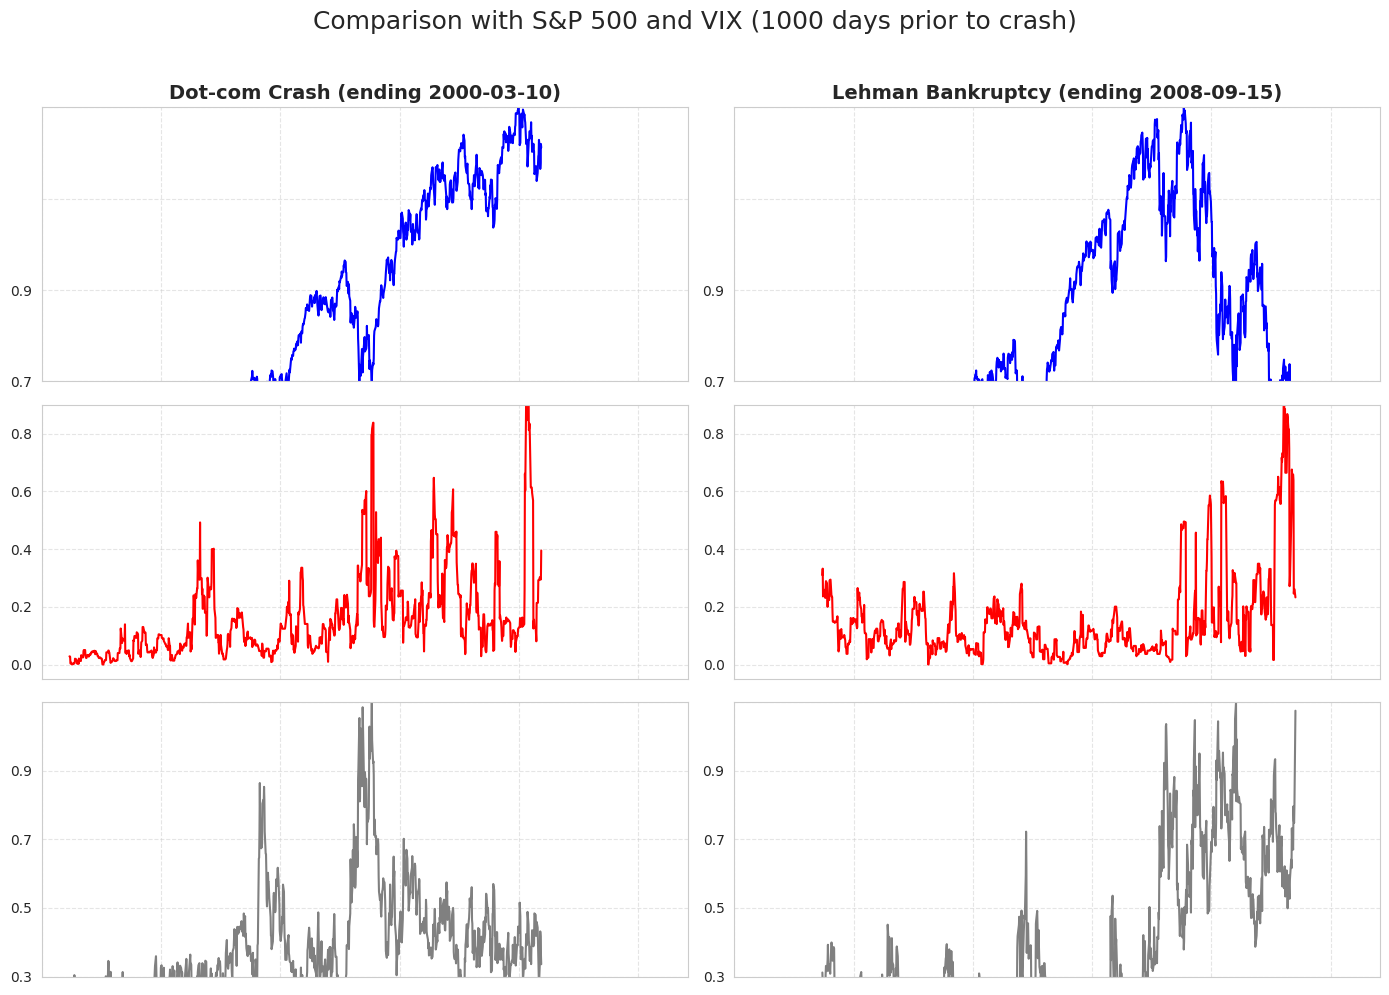

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# We assume that the 'data' (raw prices) and 'tda_norms' (L1/L2 norms) DataFrames
# already exist from previous executions.

# --- 1. RETRIEVE ADDITIONAL DATA (VIX) ---
print("Downloading historical data for the VIX index...")
start_date = "1987-12-23"
end_date = "2016-12-09"
vix_data = yf.download('^VIX', start=start_date, end=end_date)['Close']
vix_data = vix_data.ffill()
print("VIX data downloaded and prepared.")

# --- 2. HELPER FUNCTION FOR PLOTTING AND NORMALIZATION ---
def plot_crash_comparison(axes, sp500_window, l1_norm_window, vix_window, title):
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())

    sp500_norm = normalize(sp500_window)
    l1_norm_norm = normalize(l1_norm_window)
    vix_norm = normalize(vix_window)

    axes[0].plot(sp500_norm.index, sp500_norm, color='blue')
    axes[1].plot(l1_norm_norm.index, l1_norm_norm, color='red')
    axes[2].plot(vix_norm.index, vix_norm, color='gray')

    for i in range(3):
        axes[i].set_yticks(np.arange(0, 1.1, 0.2))
        axes[i].grid(True, linestyle='--', alpha=0.5)
        if i < 2:
            axes[i].set_xticklabels([])

    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_yticklabels(['', '0.5', '0.7', '0.9', '', ''])
    axes[0].set_ylim(0.4, 1.0)
    axes[1].set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', ''])
    axes[1].set_ylim(-0.05, 0.9)
    axes[2].set_yticklabels(['', '0.3', '0.5', '0.7', '0.9', ''])
    axes[2].set_ylim(0.2, 1.0)

# --- 3. MAIN SCRIPT TO CREATE THE FIGURE ---
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex='col')

crash_scenarios = [
    ('2000-03-10', 'Dot-com Crash (ending 2000-03-10)'),
    ('2008-09-15', 'Lehman Bankruptcy (ending 2008-09-15)')
]

trading_days_window = 1000

for col_idx, (date_str, title) in enumerate(crash_scenarios):
    end_date_dt = pd.to_datetime(date_str)
    print("Aligning time series (S&P 500, TDA Norms, VIX)...")

    base_index = tda_norms.index
    aligned_sp500 = data['SP500'].reindex(base_index)
    aligned_vix = vix_data.reindex(base_index)
    aligned_vix = aligned_vix.ffill().bfill()

    print("Alignment completed.")
    end_loc = aligned_sp500.index.get_loc(end_date_dt)
    start_loc = end_loc - trading_days_window + 1

    sp500_window = aligned_sp500.iloc[start_loc:end_loc+1]
    l1_norm_window = tda_norms['L1'].iloc[start_loc:end_loc+1]
    vix_window = aligned_vix.iloc[start_loc:end_loc+1]

    plot_crash_comparison(axes[:, col_idx], sp500_window, l1_norm_window, vix_window, title)

# X-axis limits to avoid clipping
axes[2, 0].set_xlim(pd.to_datetime("1996-01-01"), pd.to_datetime("2001-06-01"))
axes[2, 1].set_xlim(pd.to_datetime("2004-01-01"), pd.to_datetime("2009-06-01"))

fig.suptitle('Comparison with S&P 500 and VIX (1000 days prior to crash)', fontsize=18, y=0.99)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()